In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from random import seed
seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/As2/dataset/train.csv")
train['utterance'] = train['utterance'].astype('str')

test = pd.read_csv("/content/drive/MyDrive/As2/dataset/test.csv")
test['utterance'] = test['utterance'].astype('str')

In [4]:
train.head()

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2


In [5]:
test.head()

,utterance,act
0,I'm better now . Want to play again ?,3
1,I'll let you break the balls this time .,4
2,Let's get all the balls out of the pockets .,3
3,OK . How much do you want to bet on this game ?,2
4,You are crazy . Gambling is against my princi...,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090 entries, 0 to 5089
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  5090 non-null   object
 1   act        5090 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.7+ KB


In [7]:
train.describe()

,act
count,5090.000000
mean,1.643026
std,0.871863
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


In [8]:
test.describe()

,act
count,722.000000
mean,1.775623
std,0.946305
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


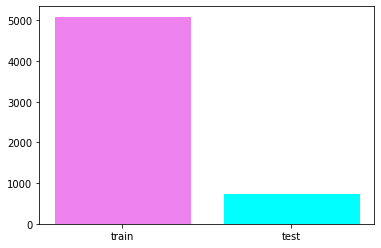

In [9]:
sizePlot = plt.bar(['train', 'test'], [train.shape[0], test.shape[0]])
sizePlot[0].set_color('violet')
sizePlot[1].set_color('cyan')

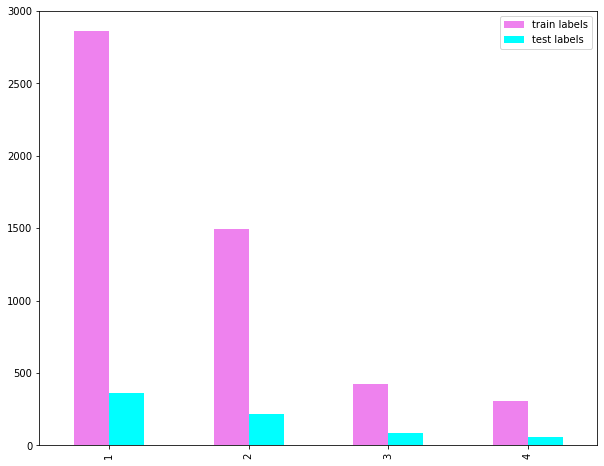

In [10]:
uniq = train['act'].value_counts().rename('train labels').to_frame()\
    .join(test['act'].value_counts().rename('test labels').to_frame())

uniq.plot(kind='bar',figsize=(10, 8), color = ['violet','cyan'])


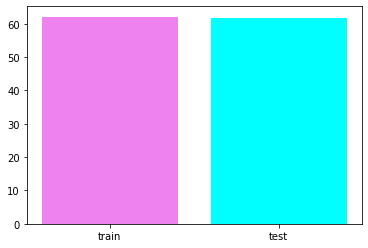

In [11]:
# Median and average sentence length lengths of train and test data
avgLenTrain = train['utterance'].apply(len).mean()
avgLenTest = test['utterance'].apply(len).mean()

avgPlot = plt.bar(['train', 'test'], [avgLenTrain, avgLenTest])
avgPlot[0].set_color('violet')
avgPlot[1].set_color('cyan')

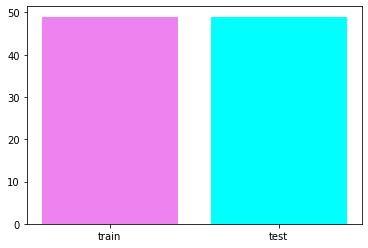

In [12]:
# Median and average sentence length lengths of train and test data
medLenTrain = train['utterance'].apply(len).median()
medLenTest = test['utterance'].apply(len).median()

medPlot = plt.bar(['train', 'test'], [medLenTrain, medLenTest])
medPlot[0].set_color('violet')
medPlot[1].set_color('cyan')

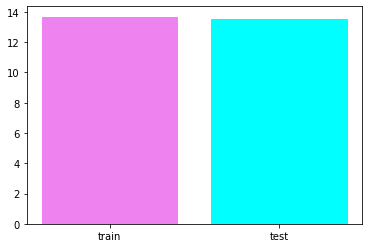

In [13]:
avgWordTrain = train.utterance.apply(lambda x:len(x.split())).mean()
avgWordTest = test.utterance.apply(lambda x:len(x.split())).mean()

numWordsPlot = plt.bar(['train', 'test'], [avgWordTrain, avgWordTest])
numWordsPlot[0].set_color('violet')
numWordsPlot[1].set_color('cyan')

In [14]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [23]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import re
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# Preprocessing of Data
tokens = spacy.load('en')

def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
    text = regex.sub(" ", text.lower())
    return [token.text for token in tokens.tokenizer(text)]

def encode_sentence(text, textVectors, N = 100):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([textVectors.get(word, textVectors["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

# Updating the frequency of each word
counts = Counter()
for index, row in train.iterrows():
    counts.update(tokenize(row['utterance']))

textVectors = {"" : 0, "UNK" : 1}
words = ["", "UNK"]

for word in counts:
    textVectors[word] = len(words)
    words.append(word)

In [18]:
class DialogueDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Utterance, Label, Context
        return torch.from_numpy(self.X[idx][0][0].astype(np.int32)), self.y[idx], torch.from_numpy(self.X[idx][1][0].astype(np.int32))

class intentPredictionNN(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim_x, embedding_dim_c, hidden_dim_x, hidden_dim_c, con = 0) :
        super().__init__()
        
        self.con = con
        self.embeddings1 = nn.Embedding(vocab_size, embedding_dim_x, padding_idx=0)

        if (con == 0):
            self.lstm1 = nn.LSTM(embedding_dim_x, hidden_dim_x, batch_first = True)
        else:
            self.embeddings2 = nn.Embedding(vocab_size, embedding_dim_c, padding_idx = 0)
            self.lstm1 = nn.LSTM(embedding_dim_x + hidden_dim_c, hidden_dim_x, batch_first = True)
            self.lstm2 = nn.LSTM(embedding_dim_c, hidden_dim_c, batch_first = True)

        self.linear = nn.Linear(hidden_dim_x, 4)
        
    
    def forward(self, x, c):
        if (self.con != 0):
            c = self.embeddings2(c)
            lstm2_out, (ht2, ct2) = self.lstm2(c)
            x = self.embeddings1(x)
            final = torch.cat((lstm2_out, x), 2)
            lstm_out, (ht, ct) = self.lstm1(final)
            return self.linear(ht[-1])

        else:
            x = self.embeddings1(x)
            lstm_out, (ht, ct) = self.lstm1(x)
            return self.linear(ht[-1])

In [32]:
def trainModel(model, epochs = 10, lr = 2e-5):
    parameters = filter(lambda p: p.requires_grad, model.parameters())

    optimizer = torch.optim.Adam(parameters, lr = lr)
    history = {}
    metrics = ['trainingLoss', 'validationLoss', 'trainingAccuracy', 'validationAccuracy', 'trainingRMSE', 'validationRMSE', 'trainingF1score', 'validationF1score']    
    
    for i in metrics:
        history[i] = []

    for i in range(epochs):
        model.train()
        sLoss = 0.0
        totalLen = 0
        for x, y, c in train_dl:
            x = x.long()
            x = x.to(device)
            y = y.long()
            y = y.to(device)
            c = c.to(device)
            
            yPred = model(x, c)
            yPred = yPred.to(device)
            
            optimizer.zero_grad()
            loss = F.cross_entropy(yPred, y)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            
            
        valLoss, valAcc, valRmse, valF1 = fmetrics(model, test_dl)
        trainLoss, trainAcc, trainRmse, trainF1 = fmetrics(model, train_dl)
        scores = [trainLoss, valLoss, trainAcc, valAcc, trainRmse, valRmse, trainF1, valF1]
        
        if i % 5 == 1:
            print("Epoch %.1f: Training Loss %.3f, Validation Loss %.3f and Validation Accuracy %.3f" % (i, trainAcc, valLoss, valAcc))

        
        for k in range(len(metrics)):
            history[metrics[k]].append(scores[k]) 

    return history

def fmetrics (model, test_dl):
    model.eval()
    
    totalLen = 0
    sLoss = 0.0
    
    ypred = np.array([])
    ytrue = np.array([])
    
    for x, y, c in test_dl: 
        x = x.long()
        x = x.to(device)
        y = y.long()
        y = y.to(device)
        c = c.to(device)
        y_hat = model(x, c)
        y_hat = y_hat.to(device)
        loss = F.cross_entropy(y_hat, y)
        loss = loss.to(device)
        pred = torch.max(y_hat, 1)[1]
        ypred = np.append(ypred, pred.cpu().detach().numpy(), 0)
        ytrue = np.append(ytrue, y.cpu().detach().numpy(), 0)
        totalLen += y.shape[0]
        sLoss += loss.item()*y.shape[0]
        
    accuracy = accuracy_score(ytrue, ypred)
    rmse = mean_squared_error(ytrue, ypred, squared = False)
    f1 = f1_score(ytrue, ypred, average = "weighted") 
    
    return sLoss/totalLen, accuracy, rmse, f1

In [21]:
maxX = 5 # Maximum context possible


lags = range(1, maxX+1)
trainC = train.assign(**{
    f'(t-{lag})': train['utterance'].shift(lag)
    for lag in lags
})

testC = test.assign(**{
    f'(t-{lag})': test['utterance'].shift(lag)
    for lag in lags
})

# from sklearn import preprocessing
le = preprocessing.LabelEncoder()
trainC['act'] = le.fit_transform(trainC['act'])
testC['act'] = le.transform(testC['act'])

trainC.fillna("", inplace = True)
testC.fillna("", inplace = True)


trainC["1"] = trainC["(t-1)"]
testC["1"] = testC["(t-1)"]

for i in range(2, maxX+1):
    trainC[str(i)] =  ['']*trainC.shape[0]
    testC[str(i)] =  ['']*testC.shape[0]
    for j in range(i, 0, -1):
        trainC[str(i)] += trainC['(t-' + str(j) + ")"]
        testC[str(i)] += testC['(t-' + str(j) + ")"]


trainC['encoded'] = train['utterance'].apply(lambda x: np.array(encode_sentence(x,textVectors )))
testC['encoded'] = test['utterance'].apply(lambda x: np.array(encode_sentence(x,textVectors )))

for i in range(1, maxX+1):
    trainC[str(i)] = trainC[str(i)].apply(lambda x: np.array(encode_sentence(x,textVectors )))
    testC[str(i)] = testC[str(i)].apply(lambda x: np.array(encode_sentence(x,textVectors )))


trainC.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

,utterance,act,(t-1),(t-2),(t-3),(t-4),(t-5),1,2,3,4,5,encoded
0,"Say , Jim , how about going for a few beers af...",2,,,,,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3..."
1,You know that is tempting but is really not g...,3,"Say , Jim , how about going for a few beers af...",,,,,"[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3...","[[14, 15, 16, 17, 18, 19, 20, 18, 21, 22, 23, ..."
2,What do you mean ? It will help us to relax .,1,You know that is tempting but is really not g...,"Say , Jim , how about going for a few beers af...",,,,"[[14, 15, 16, 17, 18, 19, 20, 18, 21, 22, 23, ...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[14, 26, 27, 15, 28, 3, 29, 30, 31, 32, 33, 3..."
3,Do you really think so ? I don't . It will ju...,1,What do you mean ? It will help us to relax .,You know that is tempting but is really not g...,"Say , Jim , how about going for a few beers af...",,,"[[14, 26, 27, 15, 28, 3, 29, 30, 31, 32, 33, 3...","[[14, 15, 16, 17, 18, 19, 20, 18, 21, 22, 23, ...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[14, 27, 15, 21, 35, 36, 3, 37, 38, 39, 3, 29..."
4,I guess you are right.But what shall we do ? ...,1,Do you really think so ? I don't . It will ju...,What do you mean ? It will help us to relax .,You know that is tempting but is really not g...,"Say , Jim , how about going for a few beers af...",,"[[14, 27, 15, 21, 35, 36, 3, 37, 38, 39, 3, 29...","[[14, 26, 27, 15, 28, 3, 29, 30, 31, 32, 33, 3...","[[14, 15, 16, 17, 18, 19, 20, 18, 21, 22, 23, ...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[14, 37, 49, 15, 50, 51, 20, 26, 52, 53, 27, ..."


intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)
Epoch 1.0: Training Loss 0.562, Validation Loss 1.182 and Validation Accuracy 0.503
Epoch 6.0: Training Loss 0.562, Validation Loss 1.176 and Validation Accuracy 0.503
Epoch 11.0: Training Loss 0.562, Validation Loss 1.175 and Validation Accuracy 0.503
Epoch 16.0: Training Loss 0.562, Validation Loss 1.175 and Validation Accuracy 0.503
Epoch 21.0: Training Loss 0.562, Validation Loss 1.175 and Validation Accuracy 0.503
Epoch 26.0: Training Loss 0.562, Validation Loss 1.170 and Validation Accuracy 0.503
Epoch 31.0: Training Loss 0.562, Validation Loss 1.174 and Validation Accuracy 0.503
Epoch 36.0: Training Loss 0.562, Validation Loss 1.174 and Validation Accuracy 0.503
Epoch 41.0: Training Loss 0.562, Validation Loss 1.174 and Validation Accuracy 0.503
Epoch 46.0: Training Loss 0.562, Validation Loss 1.174 and 

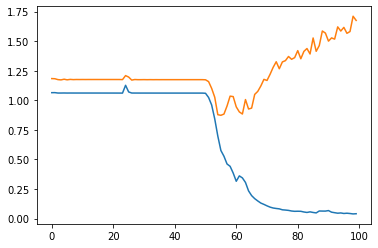

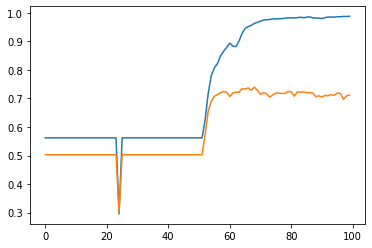

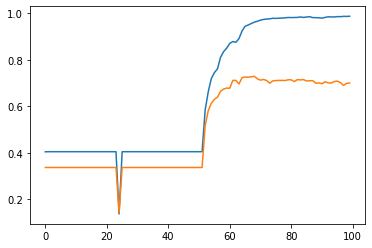

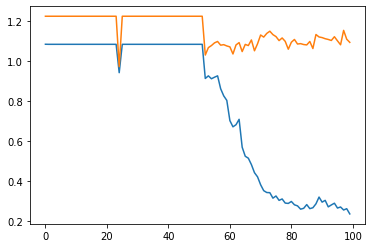

In [36]:
# Context = 0


X = 0 # Change Context here
trainF = trainC[['encoded', str(X+1)]]
testF = testC[['encoded', str(X+1)]]

train_ds = DialogueDataset(trainF.values, trainC['act'])
test_ds = DialogueDataset(testF.values, testC['act'])

batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size=batch_size)

model_c0 =  intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 0)
model_c0.to(device)
print(model_c0)

history_c0 = trainModel(model_c0, epochs = 100, lr = 0.01)

plt.plot(list(range(100)), history_c0['trainingLoss'])
plt.plot(list(range(100)), history_c0['validationLoss'])
plt.show()


plt.plot(list(range(100)), history_c0['trainingAccuracy'])
plt.plot(list(range(100)), history_c0['validationAccuracy'])
plt.show()


plt.plot(list(range(100)), history_c0['trainingF1score'])
plt.plot(list(range(100)), history_c0['validationF1score'])
plt.show()


plt.plot(list(range(100)), history_c0['trainingRMSE'])
plt.plot(list(range(100)), history_c0['validationRMSE'])
plt.show()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)
Epoch 1.0: Training Loss 0.562, Validation Loss 1.172 and Validation Accuracy 0.503
Epoch 6.0: Training Loss 0.562, Validation Loss 1.177 and Validation Accuracy 0.503
Epoch 11.0: Training Loss 0.563, Validation Loss 1.176 and Validation Accuracy 0.503
Epoch 16.0: Training Loss 0.563, Validation Loss 1.176 and Validation Accuracy 0.503
Epoch 21.0: Training Loss 0.563, Validation Loss 1.176 and Validation Accuracy 0.503
Epoch 26.0: Training Loss 0.563, Validation Loss 1.173 and Validation Accuracy 0.504
Epoch 31.0: Training Loss 0.562, Validation Loss 1.175 and Validation Accuracy 0.503
Epoch 36.0: Training Loss 0.562, Validation Loss 1.146 and Validation Accuracy 0.503
Epoch 41.0: Training Loss 0.817, Validation Loss 

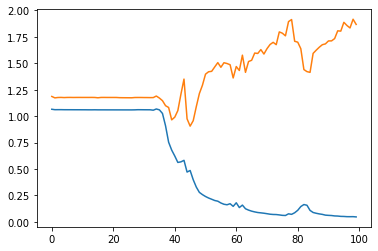

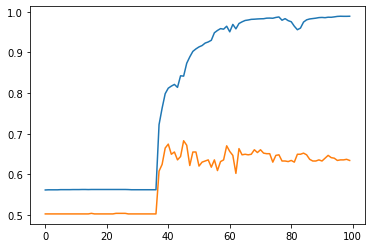

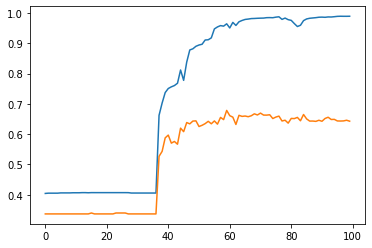

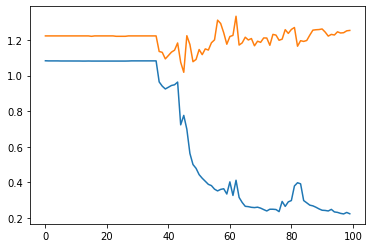

In [27]:
Context = 1

X = 1 # Change Context here
trainF = trainC[['encoded', str(X)]]
testF = testC[['encoded', str(X)]]

train_ds = DialogueDataset(trainF.values, trainC['act'])
test_ds = DialogueDataset(testF.values, testC['act'])

batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size)

model_c1 =  intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 1)
model_c1.to(device)
print(model_c1)

history_c1 = trainModel(model_c1, epochs = 100, lr = 0.01)


plt.plot(list(range(100)), history_c1['trainingLoss'])
plt.plot(list(range(100)), history_c1['validationLoss'])
plt.show()


plt.plot(list(range(100)), history_c1['trainingAccuracy'])
plt.plot(list(range(100)), history_c1['validationAccuracy'])
plt.show()


plt.plot(list(range(100)), history_c1['trainingF1score'])
plt.plot(list(range(100)), history_c1['validationF1score'])
plt.show()


plt.plot(list(range(100)), history_c1['trainingRMSE'])
plt.plot(list(range(100)), history_c1['validationRMSE'])
plt.show()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)
Epoch 1.0: Train loss 1.066, Val loss 1.171, Val accuracy 0.503, and Val rmse 1.218
Epoch 6.0: Train loss 1.060, Val loss 1.174, Val accuracy 0.503, and Val rmse 1.214
Epoch 11.0: Train loss 1.057, Val loss 1.181, Val accuracy 0.503, and Val rmse 1.218
Epoch 16.0: Train loss 1.057, Val loss 1.180, Val accuracy 0.500, and Val rmse 1.219
Epoch 21.0: Train loss 1.055, Val loss 1.185, Val accuracy 0.499, and Val rmse 1.215
Epoch 26.0: Train loss 1.043, Val loss 1.188, Val accuracy 0.497, and Val rmse 1.220
Epoch 31.0: Train loss 0.561, Val loss 1.078, Val accuracy 0.666, and Val rmse 1.088
Epoch 36.0: Train loss 0.442, Val loss 1.480, Val accuracy 0.615, and Val rmse 1.145
Epoch 41.0: Train loss 0.317, Val loss 1.094, Val

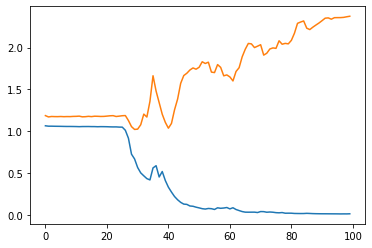

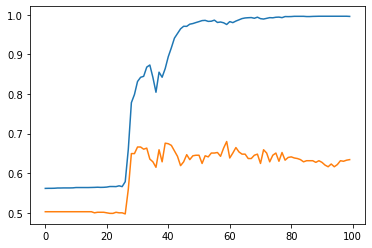

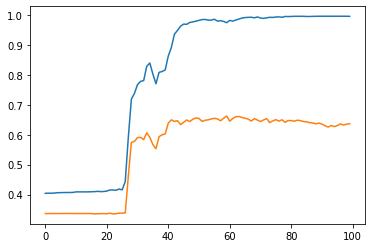

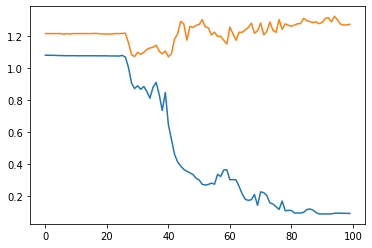

In [ ]:
# Context = 2

X = 2 # Change Context here

trainF = trainC[['encoded', str(X)]]
testF = testC[['encoded', str(X)]]

train_ds = DialogueDataset(trainF.values, trainC['act'])
test_ds = DialogueDataset(testF.values, testC['act'])

batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size)

model_c2 =  intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 2)
model_c2.to(device)
print(model_c2)

history_c2 = trainModel(model_c2, epochs = 100, lr = 0.01)

plt.plot(list(range(100)), history_c2['trainingLoss'])
plt.plot(list(range(100)), history_c2['validationLoss'])
plt.show()


plt.plot(list(range(100)), history_c2['trainingAccuracy'])
plt.plot(list(range(100)), history_c2['validationAccuracy'])
plt.show()


plt.plot(list(range(100)), history_c2['trainingF1score'])
plt.plot(list(range(100)), history_c2['validationF1score'])
plt.show()


plt.plot(list(range(100)), history_c2['trainingRMSE'])
plt.plot(list(range(100)), history_c2['validationRMSE'])
plt.show()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)
Epoch 1.0: Train loss 1.065, Val loss 1.187, Val accuracy 0.503, and Val rmse 1.218
Epoch 6.0: Train loss 1.049, Val loss 1.221, Val accuracy 0.503, and Val rmse 1.217
Epoch 11.0: Train loss 1.034, Val loss 1.194, Val accuracy 0.503, and Val rmse 1.217
Epoch 16.0: Train loss 1.029, Val loss 1.200, Val accuracy 0.500, and Val rmse 1.216
Epoch 21.0: Train loss 1.021, Val loss 1.198, Val accuracy 0.503, and Val rmse 1.220
Epoch 26.0: Train loss 1.000, Val loss 1.261, Val accuracy 0.493, and Val rmse 1.192
Epoch 31.0: Train loss 0.895, Val loss 1.089, Val accuracy 0.604, and Val rmse 0.982
Epoch 36.0: Train loss 0.396, Val loss 1.011, Val accuracy 0.675, and Val rmse 1.083
Epoch 41.0: Train loss 0.255, Val loss 1.305, Val

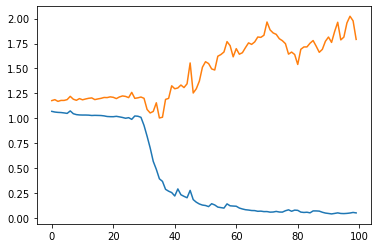

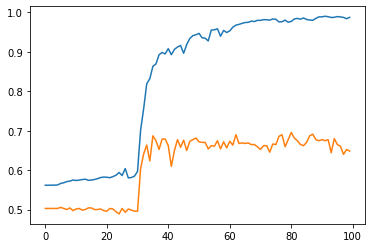

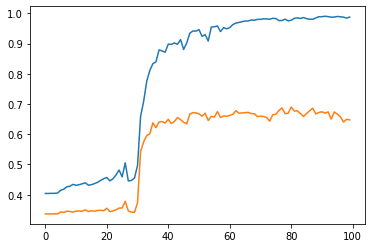

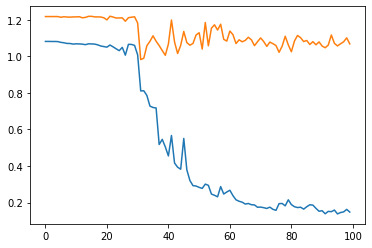

In [ ]:
X = 3 # Change Context here

trainF = trainC[['encoded', str(X)]]
testF = testC[['encoded', str(X)]]

train_ds = DialogueDataset(trainF.values, trainC['act'])
test_ds = DialogueDataset(testF.values, testC['act'])

batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size)

model_c3 =  intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 3)
model_c3.to(device)
print(model_c3)

history_c3 = trainModel(model_c3, epochs = 100, lr = 0.01)

plt.plot(list(range(100)), history_c3['trainingLoss'])
plt.plot(list(range(100)), history_c3['validationLoss'])
plt.show()


plt.plot(list(range(100)), history_c3['trainingAccuracy'])
plt.plot(list(range(100)), history_c3['validationAccuracy'])
plt.show()


plt.plot(list(range(100)), history_c3['trainingF1score'])
plt.plot(list(range(100)), history_c3['validationF1score'])
plt.show()


plt.plot(list(range(100)), history_c3['trainingRMSE'])
plt.plot(list(range(100)), history_c3['validationRMSE'])
plt.show()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)
Epoch 1.0: Train loss 1.064, Val loss 1.171, Val accuracy 0.503, and Val rmse 1.218
Epoch 6.0: Train loss 1.037, Val loss 1.195, Val accuracy 0.503, and Val rmse 1.219
Epoch 11.0: Train loss 0.980, Val loss 1.247, Val accuracy 0.504, and Val rmse 1.211
Epoch 16.0: Train loss 0.962, Val loss 1.265, Val accuracy 0.500, and Val rmse 1.210
Epoch 21.0: Train loss 0.934, Val loss 1.328, Val accuracy 0.504, and Val rmse 1.201
Epoch 26.0: Train loss 0.913, Val loss 1.274, Val accuracy 0.501, and Val rmse 1.217
Epoch 31.0: Train loss 0.826, Val loss 1.364, Val accuracy 0.510, and Val rmse 1.160
Epoch 36.0: Train loss 0.683, Val loss 1.544, Val accuracy 0.503, and Val rmse 1.183
Epoch 41.0: Train loss 0.593, Val loss 1.474, Val

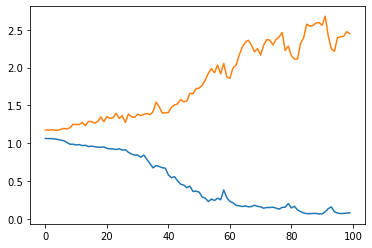

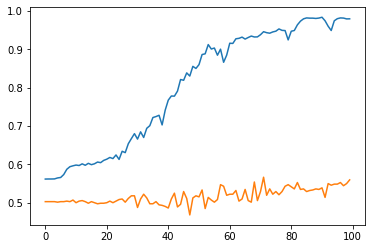

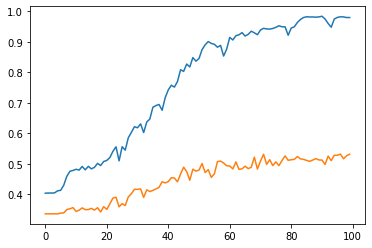

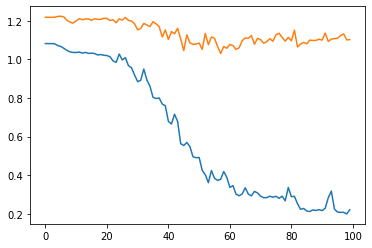

In [ ]:
X = 4 # Change Context here

trainF = trainC[['encoded', str(X)]]
testF = testC[['encoded', str(X)]]

train_ds = DialogueDataset(trainF.values, trainC['act'])
test_ds = DialogueDataset(testF.values, testC['act'])

batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size)
 
model_c4 =  intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 4)
model_c4.to(device)
print(model_c4)

history_c4 = trainModel(model_c4, epochs = 100, lr = 0.01)

plt.plot(list(range(100)), history_c4['trainingLoss'])
plt.plot(list(range(100)), history_c4['validationLoss'])
plt.show()


plt.plot(list(range(100)), history_c4['trainingAccuracy'])
plt.plot(list(range(100)), history_c4['validationAccuracy'])
plt.show()


plt.plot(list(range(100)), history_c4['trainingF1score'])
plt.plot(list(range(100)), history_c4['validationF1score'])
plt.show()


plt.plot(list(range(100)), history_c4['trainingRMSE'])
plt.plot(list(range(100)), history_c4['validationRMSE'])
plt.show()

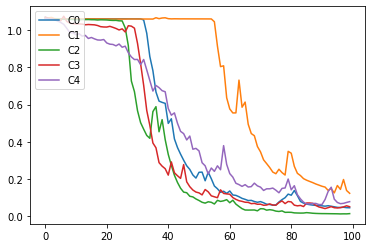

In [ ]:
# All 5 plots together for loss in Training
plt.plot(list(range(100)), history_c0['trainingLoss'], label = "C0")
plt.plot(list(range(100)), history_c1['trainingLoss'], label = "C1")
plt.plot(list(range(100)), history_c2['trainingLoss'], label = "C2")
plt.plot(list(range(100)), history_c3['trainingLoss'], label = "C3")
plt.plot(list(range(100)), history_c4['trainingLoss'], label = "C4")
plt.legend(loc="upper left")

plt.show()

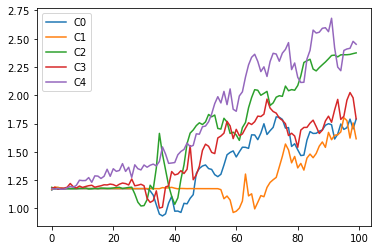

In [ ]:
# All 5 plots together for loss in Validation
plt.plot(list(range(100)), history_c0['validationLoss'], label = "C0")
plt.plot(list(range(100)), history_c1['validationLoss'], label = "C1")
plt.plot(list(range(100)), history_c2['validationLoss'], label = "C2")
plt.plot(list(range(100)), history_c3['validationLoss'], label = "C3")
plt.plot(list(range(100)), history_c4['validationLoss'], label = "C4")
plt.legend(loc="upper left")

plt.show()

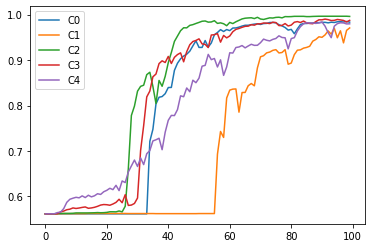

In [ ]:
# All 5 plots together for Accuracy in Training
plt.plot(list(range(100)), history_c0['trainingAccuracy'], label = "C0")
plt.plot(list(range(100)), history_c1['trainingAccuracy'], label = "C1")
plt.plot(list(range(100)), history_c2['trainingAccuracy'], label = "C2")
plt.plot(list(range(100)), history_c3['trainingAccuracy'], label = "C3")
plt.plot(list(range(100)), history_c4['trainingAccuracy'], label = "C4")
plt.legend(loc="upper left")

plt.show()

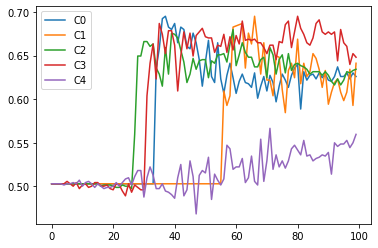

In [ ]:
# All 5 plots together for Accuracy in Validation
plt.plot(list(range(100)), history_c0['validationAccuracy'], label = "C0")
plt.plot(list(range(100)), history_c1['validationAccuracy'], label = "C1")
plt.plot(list(range(100)), history_c2['validationAccuracy'], label = "C2")
plt.plot(list(range(100)), history_c3['validationAccuracy'], label = "C3")
plt.plot(list(range(100)), history_c4['validationAccuracy'], label = "C4")
plt.legend(loc="upper left")

plt.show()

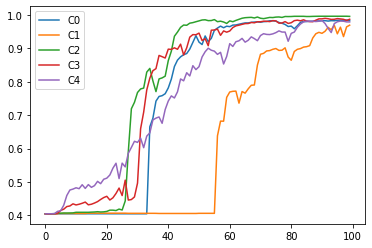

In [ ]:
# All 5 plots together for F1 score in Training
plt.plot(list(range(100)), history_c0['trainingF1score'], label = "C0")
plt.plot(list(range(100)), history_c1['trainingF1score'], label = "C1")
plt.plot(list(range(100)), history_c2['trainingF1score'], label = "C2")
plt.plot(list(range(100)), history_c3['trainingF1score'], label = "C3")
plt.plot(list(range(100)), history_c4['trainingF1score'], label = "C4")
plt.legend(loc="upper left")

plt.show()

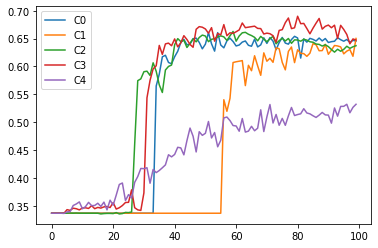

In [ ]:
# All 5 plots together for F1 score in Validation
plt.plot(list(range(100)), history_c0['validationF1score'], label = "C0")
plt.plot(list(range(100)), history_c1['validationF1score'], label = "C1")
plt.plot(list(range(100)), history_c2['validationF1score'], label = "C2")
plt.plot(list(range(100)), history_c3['validationF1score'], label = "C3")
plt.plot(list(range(100)), history_c4['validationF1score'], label = "C4")
plt.legend(loc="upper left")

plt.show()

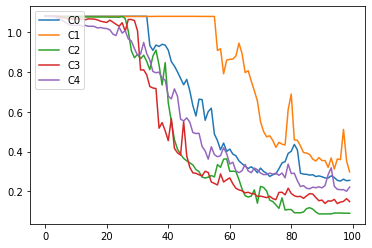

In [ ]:
# All 5 plots together for rmse score in Validation
plt.plot(list(range(100)), history_c0['trainingRMSE'], label = "C0")
plt.plot(list(range(100)), history_c1['trainingRMSE'], label = "C1")
plt.plot(list(range(100)), history_c2['trainingRMSE'], label = "C2")
plt.plot(list(range(100)), history_c3['trainingRMSE'], label = "C3")
plt.plot(list(range(100)), history_c4['trainingRMSE'], label = "C4")
plt.legend(loc="upper left")

plt.show()

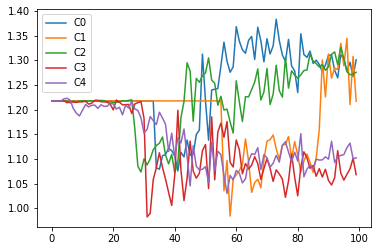

In [ ]:
# All 5 plots together for rmse score in Validation
plt.plot(list(range(100)), history_c0['validationRMSE'], label = "C0")
plt.plot(list(range(100)), history_c1['validationRMSE'], label = "C1")
plt.plot(list(range(100)), history_c2['validationRMSE'], label = "C2")
plt.plot(list(range(100)), history_c3['validationRMSE'], label = "C3")
plt.plot(list(range(100)), history_c4['validationRMSE'], label = "C4")
plt.legend(loc="upper left")

plt.show()

In [28]:
PATH = "/content/drive/MyDrive/As2/models/C0-e100-gpu.pt"
# torch.save(model_c0.state_dict(), PATH)
model_c0_l = intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 0)
model_c0_l.to(device)
model_c0_l.load_state_dict(torch.load(PATH))
model_c0_l.eval()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [30]:
print(fmetrics(model_c0_l, test_dl))

(1.789561949278179, 0.6260387811634349, 1.3015013704082357, 0.6455749778456679)


In [29]:
PATH = "/content/drive/MyDrive/As2/models/C1-e100-gpu.pt"
# torch.save(model_c1.state_dict(), PATH)
model_c1_l = intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 1)
model_c1_l.to(device)
model_c1_l.load_state_dict(torch.load(PATH))
model_c1_l.eval()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [31]:
print(fmetrics(model_c1_l, test_dl))

(1.615699967519068, 0.6412742382271468, 1.2219143964467263, 0.6502266424264693)


In [ ]:
PATH = "/content/drive/MyDrive/As2/models/C2-e100-gpu.pt"
torch.save(model_c2.state_dict(), PATH)
model_c2_l = intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 1)
model_c2_l.to(device)
model_c2_l.load_state_dict(torch.load(PATH))
model_c2_l.eval()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
print(fmetrics(model_c2_l, test_dl))

(2.2708686233557493, tensor(0.6316, device='cuda:0'), 1.31786076568615, 0.6345330045323702)


In [ ]:
PATH = "/content/drive/MyDrive/As2/models/C3-e100-gpu.pt"
torch.save(model_c3.state_dict(), PATH)
model_c3_l = intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 1)
model_c3_l.to(device)
model_c3_l.load_state_dict(torch.load(PATH))
model_c3_l.eval()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
print(fmetrics(model_c3_l, test_dl))

(1.9067442836523716, tensor(0.6316, device='cuda:0'), 1.1244268116607596, 0.6302944145087536)


In [ ]:
PATH = "/content/drive/MyDrive/As2/models/C4-e100-gpu.pt"
torch.save(model_c4.state_dict(), PATH)
model_c4_l = intentPredictionNN(vocab_size, 50, 50, 50, 50, con = 1)
model_c4_l.to(device)
model_c4_l.load_state_dict(torch.load(PATH))
model_c4_l.eval()

intentPredictionNN(
  (embeddings1): Embedding(4802, 50, padding_idx=0)
  (embeddings2): Embedding(4802, 50, padding_idx=0)
  (lstm1): LSTM(100, 50, batch_first=True)
  (lstm2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
print(fmetrics(model_c4_l, test_dl))

(2.4504594069768846, tensor(0.5596, device='cuda:0'), 1.1024197393143207, 0.5320395005264938)
